<a class="anchor" id="top"></a>

# Topic Modeling with LDA to Generate Target Risk Topics
Author: Ainesh Pandey

In this notebook, we will perform topic modeling using [LDA (Latent Dirichlet Allocation)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2) on the _Lesson(s) Learned_ column of the `lessons_learned.csv` dataframe. The purpose of this analysis is to attempt to organize the different projects into risk categories. Assuming the LDA model produces meaningful risk categories, we can use the topic classification as ground truth in a modeling objective.

## Table of Contents
[Step 1: Import Packages and Data](#step-1) <br>
[Step 2: Text Preprocessing](#step-2) <br>
[Step 3: Tuning Number of Topics](#step-3) <br>
[Step 4: Categorization of Projects into Risk Topics](#step-4) <br>
[Step 5: Visualizations and Results](#step-5) <br>
[Step 6: Save Risk Classifications to CSV](#step-6) <br>

<a class="anchor" id="step-1"></a>

## Import Packages and Data

### Packages

We start by importing the required packages for this analysis.

In [1]:
# basic data science packages
import pandas as pd
import numpy as np
from operator import itemgetter
np.random.seed(5)

# gensim packages for text LDA
import gensim
from gensim import models
from gensim.models import CoherenceModel

# visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# import custom preprocessing functions that we wrote in utils.py
from scripts.utils import preprocess_list, preprocess_string_pro

### Data
We import `lessons_learned.csv` and keep only information from the _Lesson(s) Learned_ column.

In [2]:
df = pd.read_csv('../Risky Space Business Challenge Files/lessons_learned.csv',
                 usecols=['Lesson ID', 'Lesson(s) Learned'], encoding='cp1252')
df = df[df['Lesson(s) Learned'].notna()]

display(df.shape)
df.head()

(2086, 2)

,Lesson ID,Lesson(s) Learned
0,30004,Approach 1 made it difficult to understand the...
1,30101,As a result of many years of expensive lessons...
2,29801,There was an unexpectedly wide variation in el...
3,29702,"If possible, the design phase of both systems ..."
4,29103,The pinch was initially visually inspected and...


Because the *Lesson(s) Learned* column serves as the sole input for this stage of analysis, we have to remove as much noise or improper inputs as we can find from the corpus. We start by sorting the *Lesson(s) Learned* by length, expecting the shortest values to present outliers.

In [3]:
df = df.reindex(df['Lesson(s) Learned'].str.len().sort_values().index).reset_index(drop=True)

display(df.shape)
df.head(25)

(2086, 2)

,Lesson ID,Lesson(s) Learned
0,12603,See report
1,4496,See attachment
2,26803,See attached PDF.
3,5976,See attached report
4,6456,See recommendations
5,6016,See attached report
6,1838,See attached report
7,12602,See Attached Reports
8,6349,See attached document
9,6345,See attached document


We see a lot of "See report" or "See attached document" entries, which will not add any value to our LDA model. We remove these rows from analysis.

In [4]:
df = df.iloc[20:,:].reset_index(drop=True)

display(df.shape)
df.head(25)

(2066, 2)

,Lesson ID,Lesson(s) Learned
0,1308,"Heritage does not mean ""use as is""."
1,616,Don't anodize thin aluminum impeller blades.
2,1307,A satellite simulator is worth the investment.
3,304,Hardware should be functionally end-to-end tes...
4,437,Oversized mounting screws can damage capped in...
5,2156,Use RENS to transfer science data whenever pos...
6,434,"Corrosion, once started, is extremely difficul..."
7,936,Use caution when using industry terms in a spe...
8,1357,Loss of original implementation personnel and ...
9,4999,Active leveling is the safest way to lift/mate...


[Back to Top](#top)

<a class="anchor" id="step-2"></a>

## Text Preprocessing

First, we preprocess the *Lesson(s) Learned* column using the custom preprocessing function we wrote in `utils.py`. This function:
- calls the `gensim` *simple_preprocess()* function
- removes stopwords and words shorter than three letters
- stems and lemmatizes the words

In [5]:
processed_lessons = df['Lesson(s) Learned'].map(preprocess_list)

print('Original text')
print(df.iloc[10,1])
print()
print('Processed text')
print(processed_lessons[10])

Original text
Hot work permits should be issued for specific tasks only.

Processed text
['work', 'permit', 'issu', 'specif', 'task']


Next, we need to create the data structures required by the LDA package.
- dictionary: contains all of the post-processed terms in the corpus, subject to certain conditions
- corpus_bow: a bag-of-words representation of each document
- corpus_tfidf: converts the bag-of-words representation into a TFIDF (term-frequency-inverse-document-frequency) representation

In [6]:
# create dictionary, keep only terms that occur more than 10 times and in less than half of the documents, keeping a max of 100000 terms
dictionary = gensim.corpora.Dictionary(processed_lessons)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# create the corpus_bow
corpus_bow = [dictionary.doc2bow(doc) for doc in processed_lessons]

# create the corpus_tfidf
tfidf_model = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf_model[corpus_bow]

# display the first document
print('Original text')
print(df.iloc[10,1])
print()

# visualize the first 5 elements of the corpus_bow for the first document
print('Bag-of-words Representation')
print(corpus_bow[10])
print()

# visualize the tfidf representation of the first document
print('TF-IDF Representation')
print(corpus_tfidf[10])


Original text
Hot work permits should be issued for specific tasks only.

Bag-of-words Representation
[(24, 1), (35, 1), (36, 1), (37, 1), (38, 1)]

TF-IDF Representation
[(24, 0.3527474402441277), (35, 0.39367552828679253), (36, 0.6590630148804888), (37, 0.43845398928679113), (38, 0.3065662465511648)]


[Back to Top](#top)

<a class="anchor" id="step-3"></a>

## Tuning Number of Topics

Identifying the ideal number of topics is a key step of LDA. We will test different number of topics through brute-force, using a coherence value to evaluate how cohesive the topics are. We will start with two (2) topics, and test up to fifteen (15) topics.

In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = [0 for n in range(start)]

    for num_topics in range(start, limit, step):
        np.random.seed(5)
        model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, chunksize=400,
                                       random_state=5, passes=10, per_word_topics=True)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print('Done modeling for num_topics = {}, Coherence score: {}'.format(num_topics, coherencemodel.get_coherence()))

    return coherence_values

coherence_values = compute_coherence_values(dictionary, corpus_tfidf, processed_lessons, 16, start=2, step=1)

Done modeling for num_topics = 2, Coherence score: 0.4110116817095165
Done modeling for num_topics = 3, Coherence score: 0.45404715744667357
Done modeling for num_topics = 4, Coherence score: 0.3349300431473655
Done modeling for num_topics = 5, Coherence score: 0.33864329224903095
Done modeling for num_topics = 6, Coherence score: 0.32365072935039907
Done modeling for num_topics = 7, Coherence score: 0.31645741645615205
Done modeling for num_topics = 8, Coherence score: 0.34668651664399197
Done modeling for num_topics = 9, Coherence score: 0.34258501748147674
Done modeling for num_topics = 10, Coherence score: 0.3830176327456522
Done modeling for num_topics = 11, Coherence score: 0.336378192137393
Done modeling for num_topics = 12, Coherence score: 0.3690294694105229
Done modeling for num_topics = 13, Coherence score: 0.33045367409628906
Done modeling for num_topics = 14, Coherence score: 0.38581913294566117
Done modeling for num_topics = 15, Coherence score: 0.3702145997753792


An accepted practice used to identify the number of topics is the "elbow method". We will visualize the coherence scores across number of topics to identify the elbow.

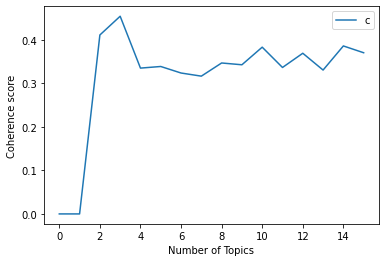

In [8]:
# Show graph
plt.plot(range(0, 16, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

According to the graph, the "elbow" (and in this case, also the best coherence score overall) is at 3 topics.

In [9]:
num_topics = 3

lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, chunksize=400,
                                   random_state=5, passes=10, per_word_topics=True)

[Back to Top](#top)

<a class="anchor" id="step-4"></a>

## Categorization of Projects into Risk Topics

We now categorize each lesson learned into one of the 3 topics, which will represent the risk classification.

In [10]:
df['Risk Class']  = [max(lda_model[corpus_tfidf[n]][0], key=itemgetter(1))[0] for n in range(len(corpus_tfidf))]

display(df.shape)
df.head()

(2066, 3)

,Lesson ID,Lesson(s) Learned,Risk Class
0,1308,"Heritage does not mean ""use as is"".",2
1,616,Don't anodize thin aluminum impeller blades.,0
2,1307,A satellite simulator is worth the investment.,2
3,304,Hardware should be functionally end-to-end tes...,2
4,437,Oversized mounting screws can damage capped in...,0


[Back to Top](#top)

<a class="anchor" id="step-5"></a>

## Visualizations and Results

### Visualizations

Let's examine the results of our risk classification. First, let's visualize the distribution of the risk classes.

0    704
1    703
2    659
Name: Risk Class, dtype: int64

Text(0.5, 1.0, 'Distribution of Risk Class')

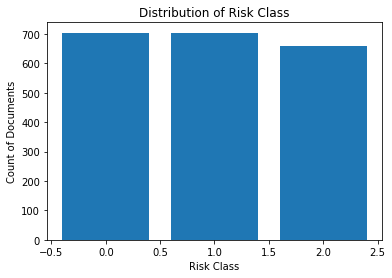

In [11]:
dist = df['Risk Class'].value_counts()
display(dist)

plt.bar(dist.index, dist)
plt.xlabel('Risk Class')
plt.ylabel('Count of Documents')
plt.title('Distribution of Risk Class')

The distribution is very even, which later on should simply the classification modeling phase. We need to further examine the composition of the documents within each topic to see if certain trends emerge.

Let's view the functions created to calculate the probability of a document from the _Lesson(s) Learned_ column belonging to a certain topic.

In [12]:
for idx, risk_class in lda_model.print_topics(-1):
    print('Risk Class: {} \n   {}'.format(idx, risk_class))

Risk Class: 0 
   0.009*"failur" + 0.009*"caus" + 0.008*"pressur" + 0.008*"damag" + 0.007*"valv" + 0.007*"instal" + 0.007*"result" + 0.007*"compon" + 0.007*"wire" + 0.007*"load"
Risk Class: 1 
   0.013*"project" + 0.010*"requir" + 0.010*"manag" + 0.009*"team" + 0.009*"contractor" + 0.009*"work" + 0.009*"review" + 0.008*"develop" + 0.008*"program" + 0.007*"process"
Risk Class: 2 
   0.016*"test" + 0.010*"design" + 0.010*"flight" + 0.009*"hardwar" + 0.009*"spacecraft" + 0.008*"cost" + 0.007*"mission" + 0.007*"risk" + 0.007*"grind" + 0.006*"oper"


We will need to access the key terms for each topic. Let's arrange them into a dataframe.

In [13]:
# create the dataframe
df_riskclass_terms = pd.DataFrame()

# for each of the 5 topics, add their key term indices and coefficients to the dataframe
for risk_class in range(num_topics):
    temp = pd.DataFrame(lda_model.get_topic_terms(risk_class))
    temp['Risk Class'] = risk_class
    df_riskclass_terms = pd.concat([df_riskclass_terms, temp], axis=0)

# add a column for the term referred to by each term index
df_riskclass_terms['Term'] = [dictionary[x] for x in df_riskclass_terms[0]]

# rearrange columns to be more intuitive
df_riskclass_terms.columns = ['Term Index', 'Term Coefficient', 'Risk Class', 'Term']
df_topic_terms = df_riskclass_terms[['Risk Class', 'Term Index', 'Term', 'Term Coefficient']]

display(df_riskclass_terms.shape)
df_riskclass_terms.head(30)

(30, 4)

,Term Index,Term Coefficient,Risk Class,Term
0,84,0.009386,0,failur
1,83,0.008896,0,caus
2,130,0.008224,0,pressur
3,9,0.007966,0,damag
4,290,0.007389,0,valv


Now, let's visualize the key terms of each topic next to the terms from all of the documents within.

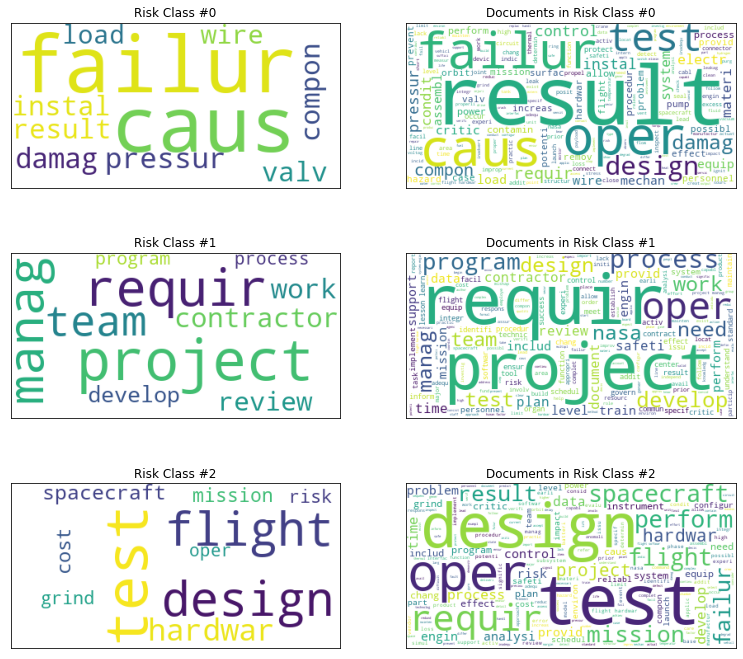

In [14]:
df_riskclass_terms.index = df_riskclass_terms['Term']
df['Lessons Processed'] = df['Lesson(s) Learned'].map(preprocess_string_pro)
fig, ax = plt.subplots(num_topics,2, figsize = (13,num_topics*4))

for risk_class in range(num_topics):
    temp_riskclass = df_riskclass_terms[df_riskclass_terms['Risk Class'] == risk_class]
    temp_docs      = ' '.join(df[df['Risk Class'] == risk_class]["Lessons Processed"])
    temp_topic_cloud = WordCloud(background_color='white').generate_from_frequencies(temp_riskclass['Term Coefficient'])
    temp_docs_cloud  = WordCloud(background_color='white').generate(temp_docs)

    ax[risk_class,0].axes.xaxis.set_visible(False)
    ax[risk_class,0].axes.yaxis.set_visible(False)
    ax[risk_class,0].title.set_text('Risk Class #{}'.format(risk_class))
    ax[risk_class,0].imshow(temp_topic_cloud)

    ax[risk_class,1].axes.xaxis.set_visible(False)
    ax[risk_class,1].axes.yaxis.set_visible(False)
    ax[risk_class,1].title.set_text('Documents in Risk Class #{}'.format(risk_class))
    ax[risk_class,1].imshow(temp_docs_cloud)

### Results

The three topics producted by LDA present three distinct, cohesive risk categories.
- `Risk Class 0`: Technical Execution Risk
    - 
- `Risk Class 1`: Managerial Process Risk
- `Risk Class 2`: Operational Cost Risk

[Back to Top](#top)

<a class="anchor" id="step-6"></a>

## Save Risk Classifications to CSV
We now save the risk classification as a csv for the modeling step.

In [15]:
df.to_csv('../data/risk_classifications.csv', columns=['Lesson ID', 'Risk Class'], index=False)

[Back to Top](#top)